In [1]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Rea

In [2]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [3]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141803 sha256=ffba3a868577eb051b9566e0682997c094e76a7b48ed97ed89f6acea2f60afc5
  Stored in directory: /root/.cache/pip/wheels/40/7b/9f/2922869bef86c3354ae7034f7a3647c573ee1997c2dad0290a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
    Running setup.py install for mecab-python: started
    Running setup.py install for mecab-python: finished with status 'done'


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [4]:
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import KeyedVectors

from tensorflow.keras.initializers import Constant
import pprint

import gensim
import gensim.models

In [5]:
train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/movie_ratings/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/movie_ratings/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) 
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [11]:
vocab_size = 10000    
word_vector_dim = 16  


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [12]:
X_val = X_train[:10000]   
y_val = y_train[:10000]


partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20   

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 8ms/step - loss: 0.4798 - accuracy: 0.7922 - val_loss: 0.3578 - val_accuracy: 0.8466
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3373 - accuracy: 0.8570 - val_loss: 0.3420 - val_accuracy: 0.8491
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3167 - accuracy: 0.8661 - val_loss: 0.3352 - val_accuracy: 0.8521
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3050 - accuracy: 0.8700 - val_loss: 0.3362 - val_accuracy: 0.8537
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2952 - accuracy: 0.8755 - val_loss: 0.3356 - val_accuracy: 0.8537
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2857 - accuracy: 0.8791 - val_loss: 0.3393 - val_accuracy: 0.8543
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2749 - accuracy: 0.8829 - val_loss: 0.3454 - val_accuracy: 0.8555
Epoch 

In [14]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5413 - accuracy: 0.8357 - 4s/epoch - 2ms/step
[0.5413153171539307, 0.8357304334640503]


In [15]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


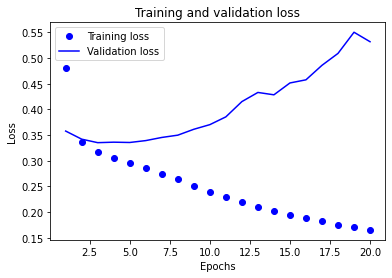

In [16]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

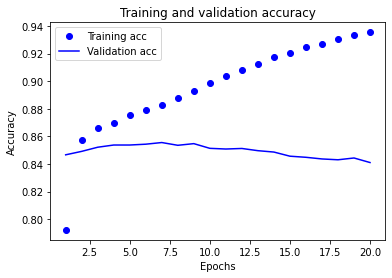

In [17]:
plt.clf()   
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [19]:
word2vec_file_path = ("/content/drive/MyDrive/Colab Notebooks/movie_ratings/word2vec_rnn.txt")
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.01869267, -0.19983435,  0.12557437,  0.00739905,  0.03243783,
        0.39274025,  0.01414399,  0.01719122,  0.02532523,  0.08193634,
       -0.14893802,  0.07802918,  0.00865892, -0.06072466, -0.00463236,
       -0.00923406], dtype=float32)

In [22]:
word_vectors.similar_by_word("재미")

[('이렇게', 0.9380940198898315),
 ('진짜', 0.89439857006073),
 ('완전', 0.8906502723693848),
 ('집중', 0.8878754377365112),
 ('정말', 0.8871647119522095),
 ('거의', 0.879216194152832),
 ('너무', 0.8507815599441528),
 ('넘', 0.8230140209197998),
 ('짠해', 0.8146696090698242),
 ('가치', 0.8083150386810303)]

In [23]:
vocab_size = 10000    
word_vector_dim = 16  


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [24]:
X_val = X_train[:10000]   
y_val = y_train[:10000]

partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.4789 - accuracy: 0.7687 - val_loss: 0.3500 - val_accuracy: 0.8464
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3275 - accuracy: 0.8604 - val_loss: 0.3304 - val_accuracy: 0.8563
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2942 - accuracy: 0.8779 - val_loss: 0.3279 - val_accuracy: 0.8565
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2671 - accuracy: 0.8913 - val_loss: 0.3265 - val_accuracy: 0.8582
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2391 - accuracy: 0.9054 - val_loss: 0.3373 - val_accuracy: 0.8555
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2100 - accuracy: 0.9194 - val_loss: 0.3646 - val_accuracy: 0.8525
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1801 - accuracy: 0.9339 - val_loss: 0.3868 - val_accuracy: 0.8493
Epoch 

In [26]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.8737 - accuracy: 0.8194 - 5s/epoch - 3ms/step
[0.873726487159729, 0.8194153308868408]


In [27]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


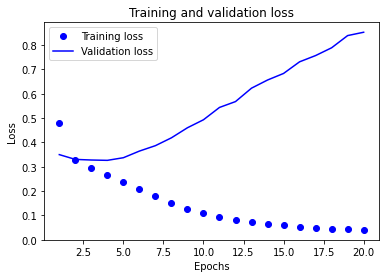

In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

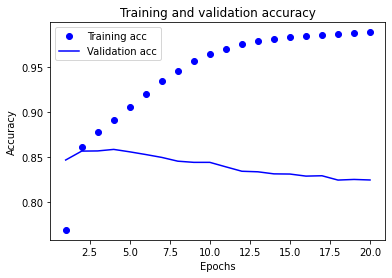

In [29]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [31]:
word2vec_file_path = ("/content/drive/MyDrive/Colab Notebooks/movie_ratings/word2vec_cnn.txt")
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.14171083,  0.04438479,  0.04970426, -0.00230057,  0.16611929,
        0.03979312,  0.14859648, -0.0479232 ,  0.00559331,  0.07430028,
       -0.12035052, -0.00530599, -0.07264458, -0.01018787,  0.11486394,
        0.0533487 ], dtype=float32)

In [34]:
word_vectors.similar_by_word("재미")

[('유죄', 0.8408588171005249),
 ('만한', 0.8132571578025818),
 ('을수록', 0.809852123260498),
 ('찾아보', 0.7896904945373535),
 ('넘', 0.7677587270736694),
 ('원장', 0.7664070725440979),
 ('떄', 0.7624630928039551),
 ('박시후', 0.7584497332572937),
 ('심은하', 0.7533740997314453),
 ('웹', 0.7493941187858582)]

In [35]:
vocab_size = 10000    
word_vector_dim = 16  


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [36]:
X_val = X_train[:10000]   
y_val = y_train[:10000]

partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 10ms/step - loss: 0.5646 - accuracy: 0.7557 - val_loss: 0.3977 - val_accuracy: 0.8288
Epoch 2/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3609 - accuracy: 0.8443 - val_loss: 0.3522 - val_accuracy: 0.8424
Epoch 3/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3182 - accuracy: 0.8654 - val_loss: 0.3450 - val_accuracy: 0.8493
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2937 - accuracy: 0.8771 - val_loss: 0.3480 - val_accuracy: 0.8489
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2752 - accuracy: 0.8866 - val_loss: 0.3523 - val_accuracy: 0.8480
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2599 - accuracy: 0.8939 - val_loss: 0.3585 - val_accuracy: 0.8472
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2469 - accuracy: 0.8999 - val_loss: 0.3657 - val_accuracy: 0.8484
Epoch

In [38]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


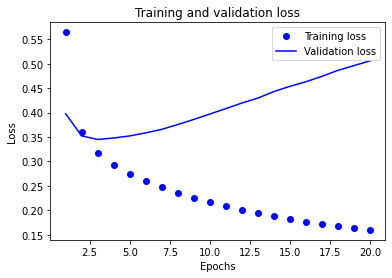

In [39]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

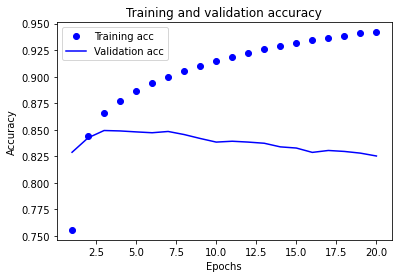

In [40]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [42]:
word2vec_file_path = ("/content/drive/MyDrive/Colab Notebooks/movie_ratings/word2vec_gmp.txt")
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [43]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [44]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.14860709, -0.22880132,  0.04299865, -0.18426251,  0.05219719,
        0.04134523, -0.1118443 , -0.34905916, -0.00414323,  0.18645777,
       -0.10054284, -0.11278304, -0.01067339,  0.00643397, -0.12457545,
       -0.09450629], dtype=float32)

In [45]:
word_vectors.similar_by_word("재미")

[('가져', 0.8416370749473572),
 ('나올까', 0.828810453414917),
 ('끗', 0.8192663192749023),
 ('아아', 0.8132162690162659),
 ('존나', 0.8104289174079895),
 ('김수로', 0.807068943977356),
 ('ㅐ', 0.7960994839668274),
 ('짝', 0.7915866374969482),
 ('아내', 0.7869472503662109),
 ('장진', 0.7862621545791626)]

In [46]:
from gensim.models import KeyedVectors

word2vec_path = ("/content/drive/MyDrive/Colab Notebooks/movie_ratings/korean_embedding/word2vec_ko.model")
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [47]:
word2vec.similar_by_word("재미")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850807189941),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552945137023926),
 ('이야기', 0.5536993741989136),
 ('연애', 0.5522936582565308),
 ('열의', 0.5464565753936768)]

In [53]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 100  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
  if index_to_word[i] in word2vec:
    embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [54]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20   

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
2128/2128 [==============================] - 15s 6ms/step - loss: 0.3950 - accuracy: 0.8184 - val_loss: 0.3242 - val_accuracy: 0.8592
Epoch 2/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.2954 - accuracy: 0.8735 - val_loss: 0.3040 - val_accuracy: 0.8675
Epoch 3/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.2564 - accuracy: 0.8923 - val_loss: 0.3115 - val_accuracy: 0.8660
Epoch 4/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.2225 - accuracy: 0.9090 - val_loss: 0.3174 - val_accuracy: 0.8705
Epoch 5/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.1900 - accuracy: 0.9244 - val_loss: 0.3403 - val_accuracy: 0.8658
Epoch 6/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.1575 - accuracy: 0.9380 - val_loss: 0.3643 - val_accuracy: 0.8668
Epoch 7/20
2128/2128 [==============================] - 14s 7ms/step - loss: 0.1281 - accuracy: 0.9507 - val_loss: 0.4045 - val_ac

In [56]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


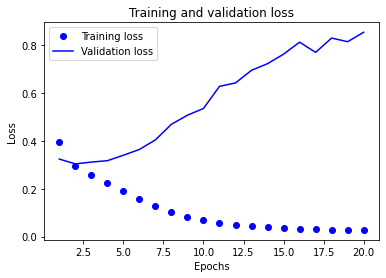

In [57]:
cc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

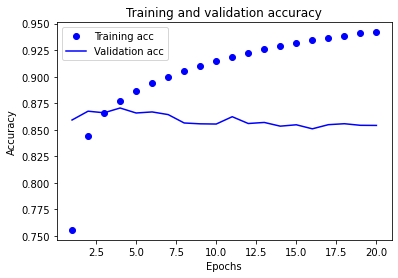

In [58]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [59]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.8631 - accuracy: 0.8509 - 4s/epoch - 2ms/step
[0.8630746603012085, 0.8509469628334045]


# 회고

초반에 라이브러리를 불러오려고 하는데 계속 오류가 떠서 문제 어디 문제인지 파악하였고 from konlpy.tag import Mecab 여기서 계속 오류가 발생했다는 것을 알고 설치를 하였다.   
이번이 3번째 NLP 익스 였던 것 같은데 여전히 NLP는 어려웠다. 토큰화, 불용어 제거 및 여러 세부 과정들이 아직까지는 낯선 느낌이였다.